# Forecasting Air Passenger Numbers with TensorFlow Probability

### Attributions

The below code uses the template from the [Structural Time Series modeling in TensorFlow Probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html) tutorial, of which the original authors **(Copyright 2019 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on air passenger data from San Francisco Open Data - the original Jupyter Notebook used Atmospheric CO2 and Electricity Demand for modelling purposes. The original source code can be found [here](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb).

#### Apache 2.0 License

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Dependencies & Prerequisites


In [2]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

### Plotting setup

Helper methods for plotting time series and forecasts.

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [5]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

dtypes = {
        'passengers': 'float64'
}

In [6]:
dataset = pd.read_csv("united-airlines.csv", dtype=dtypes)

In [7]:
a=dataset.head()
b=dataset
b

,date,passengers
0,2017-01-01,235570.0
1,2017-02-01,229345.0
2,2017-03-01,293538.0
3,2017-04-01,294672.0
4,2017-05-01,296241.0
5,2017-06-01,333176.0
6,2017-07-01,332482.0
7,2017-08-01,334397.0
8,2017-09-01,273176.0
9,2017-10-01,306651.0


In [8]:
tseries=dataset['passengers']
tseries

0     235570.0
1     229345.0
2     293538.0
3     294672.0
4     296241.0
5     333176.0
6     332482.0
7     334397.0
8     273176.0
9     306651.0
10    308896.0
11    300110.0
12    260621.0
13    247438.0
14    303894.0
15    294941.0
16    304090.0
17    335810.0
18    340073.0
19    353409.0
20    288237.0
21    297661.0
22    261493.0
23    265472.0
24    228102.0
25    206742.0
26    258267.0
27    268624.0
28    257574.0
29    296899.0
30    322605.0
31    341150.0
32    233633.0
33    284875.0
34    273015.0
35    286655.0
36    231547.0
37    215463.0
38     98620.0
39      7323.0
40      7115.0
41     10522.0
Name: passengers, dtype: float64

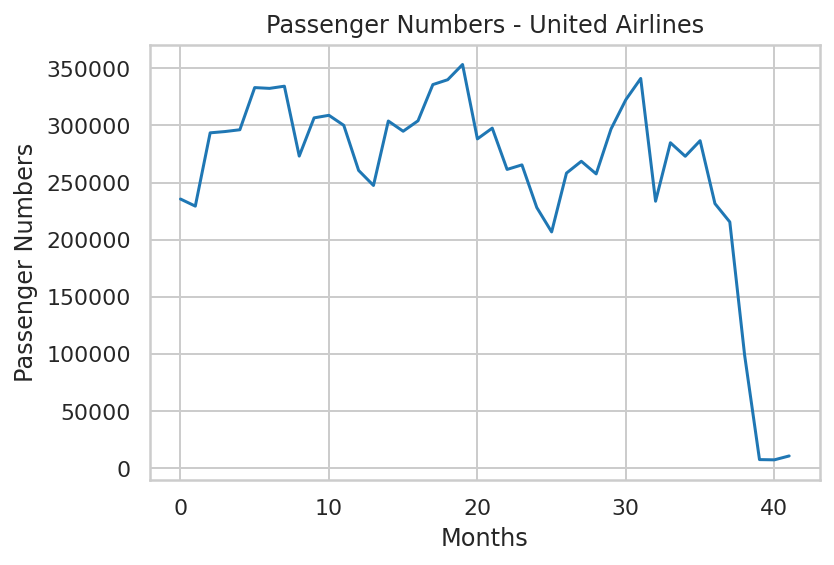

In [9]:
plt.plot(tseries)
plt.xlabel("Months")
plt.ylabel("Passenger Numbers")
plt.title("Passenger Numbers - United Airlines")
plt.show()

In [10]:
type(tseries)

pandas.core.series.Series

/home/michael/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


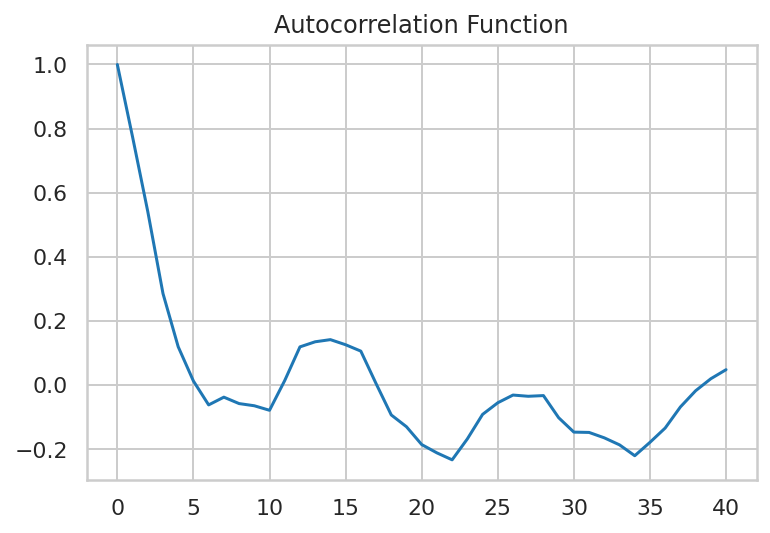

In [11]:
acfx=statsmodels.tsa.stattools.acf(tseries)
plt.plot(acfx)
plt.title("Autocorrelation Function")
plt.show()

/home/michael/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


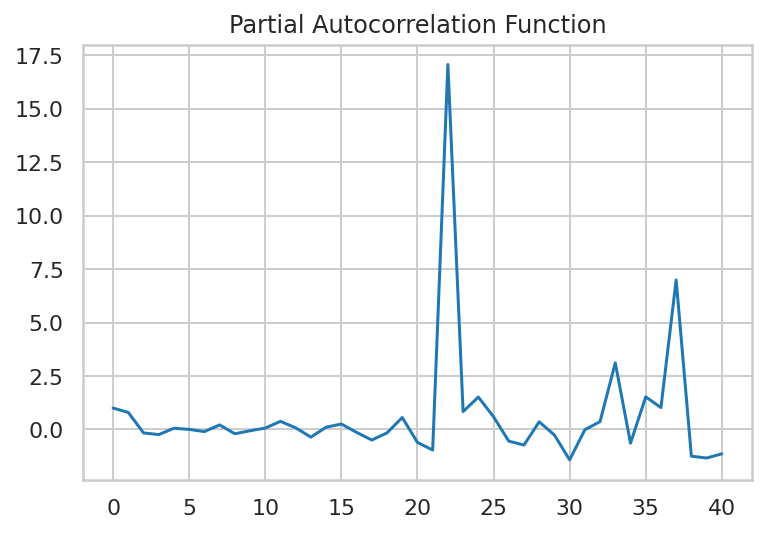

In [12]:
pacfx=statsmodels.tsa.stattools.pacf(tseries)
plt.plot(pacfx)
plt.title("Partial Autocorrelation Function")
plt.show()

In [13]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [14]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [15]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

## Training and Test Data

A model is fit to split the series into training and test data on a weekly basis.

### Data

In [16]:
num_forecast_steps = 1 * 12
tseries_training_data = tseries[:-num_forecast_steps]

tseries_dates = np.arange("2017-01-01", "2020-07-01", dtype="datetime64[M]")
tseries_loc = mdates.YearLocator(3)
tseries_fmt = mdates.DateFormatter('%Y')

In [17]:
tseries_dates

array(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06'],
      dtype='datetime64[M]')

In [18]:
tseries_training_data

0     235570.0
1     229345.0
2     293538.0
3     294672.0
4     296241.0
5     333176.0
6     332482.0
7     334397.0
8     273176.0
9     306651.0
10    308896.0
11    300110.0
12    260621.0
13    247438.0
14    303894.0
15    294941.0
16    304090.0
17    335810.0
18    340073.0
19    353409.0
20    288237.0
21    297661.0
22    261493.0
23    265472.0
24    228102.0
25    206742.0
26    258267.0
27    268624.0
28    257574.0
29    296899.0
Name: passengers, dtype: float64

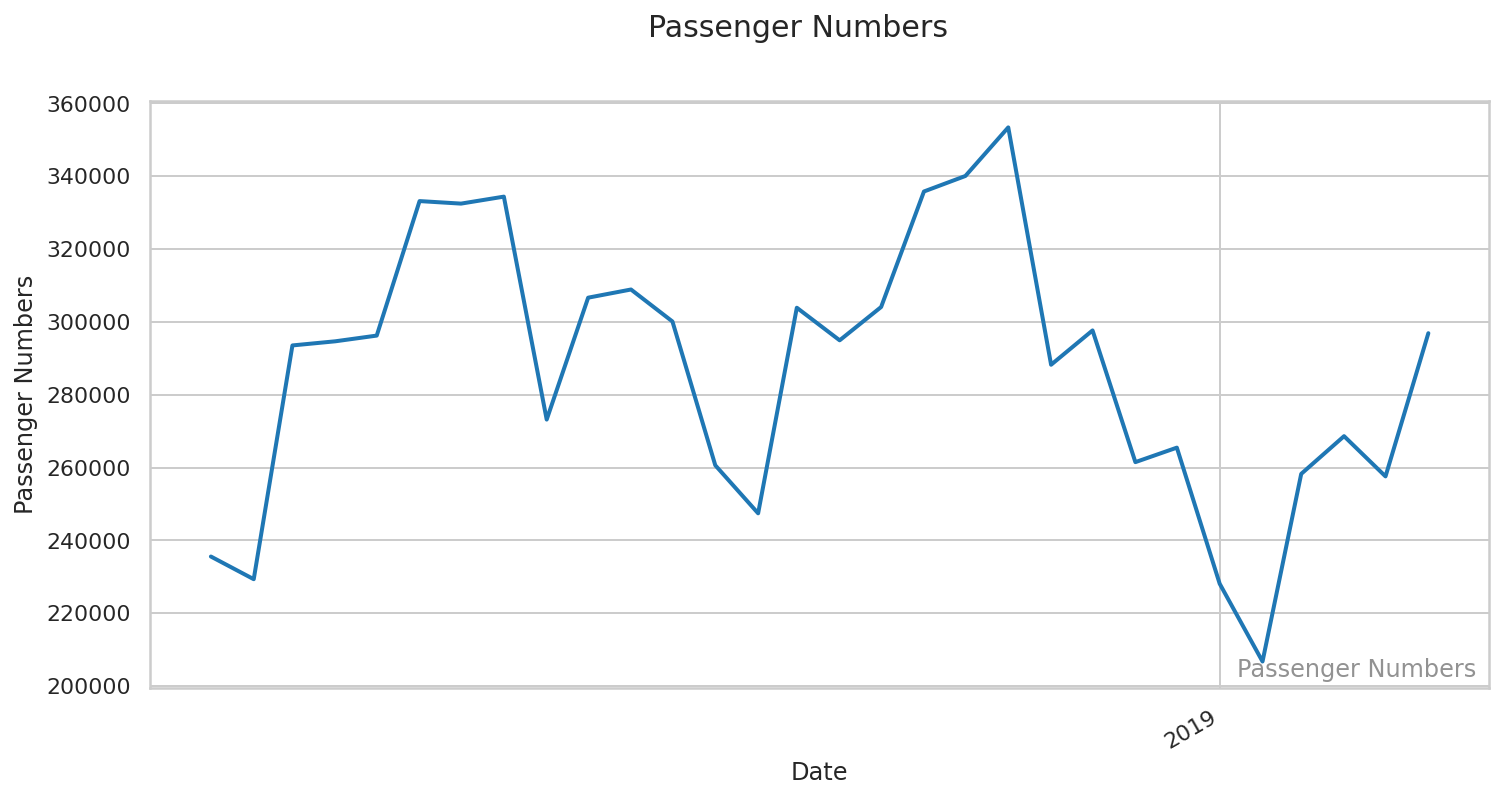

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(tseries_dates[:-num_forecast_steps], tseries_training_data, lw=2, label="training data")
ax.xaxis.set_major_locator(tseries_loc)
ax.xaxis.set_major_formatter(tseries_fmt)
ax.set_ylabel("Passenger Numbers")
ax.set_xlabel("Date")
fig.suptitle("Passenger Numbers",
             fontsize=15)
ax.text(0.99, .02,
        "Passenger Numbers",
        transform=ax.transAxes,
        horizontalalignment="right",
        alpha=0.5)
fig.autofmt_xdate()

In [20]:
type(tseries_dates[:-num_forecast_steps])

numpy.ndarray

In [21]:
tseries_training_data

0     235570.0
1     229345.0
2     293538.0
3     294672.0
4     296241.0
5     333176.0
6     332482.0
7     334397.0
8     273176.0
9     306651.0
10    308896.0
11    300110.0
12    260621.0
13    247438.0
14    303894.0
15    294941.0
16    304090.0
17    335810.0
18    340073.0
19    353409.0
20    288237.0
21    297661.0
22    261493.0
23    265472.0
24    228102.0
25    206742.0
26    258267.0
27    268624.0
28    257574.0
29    296899.0
Name: passengers, dtype: float64

In [22]:
type(tseries_training_data)

pandas.core.series.Series

### Model and Fitting

The model is fitted with a local linear trend, along with a monthly seasonal effect (num_seasons=12).

In [23]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  residual_level = tfp.sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series, name='residual')
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([trend, seasonal, residual_level, autoregressive], observed_time_series=observed_time_series)
  return model

We'll fit the model using variational inference. This involves running an optimizer to minimize a variational loss function, the negative evidence lower bound (ELBO). This fits a set of approximate posterior distributions for the parameters (in practice we assume these to be independent Normals transformed to the support space of each parameter).

The `tfp.sts` forecasting methods require posterior samples as inputs, so we'll finish by drawing a set of samples from the variational posterior.

In [24]:
tseries_model = build_model(tseries_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=tseries_model)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


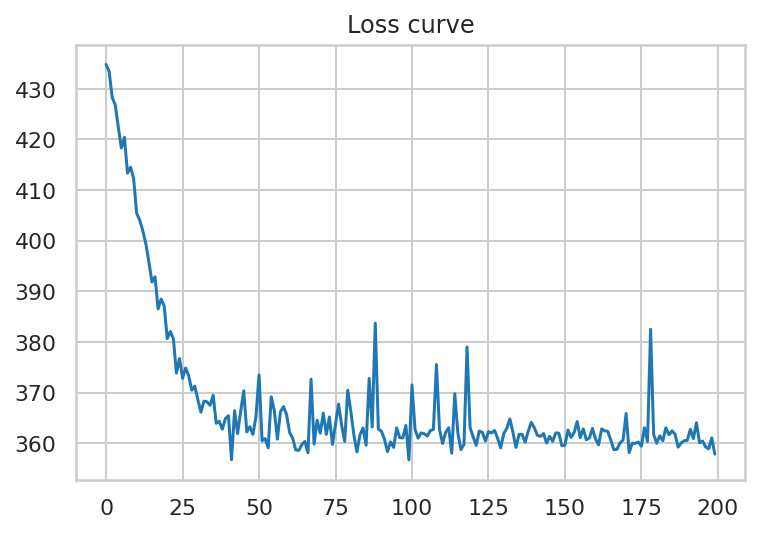

In [25]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=tseries_model.joint_log_prob(
        observed_time_series=tseries_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.title("Loss curve")
plt.show()

# Draw samples from the variational posterior.
q_samples_tseries_ = variational_posteriors.sample(50)

In [26]:
q_samples_tseries_

OrderedDict([('observation_noise_scale',
              <tf.Tensor: shape=(50,), dtype=float64, numpy=
              array([ 2853.62681146,  1964.16086649,  1919.62937352,   455.05161757,
                       466.62192386,   416.6315731 ,   362.93931993, 11261.83203929,
                       909.17842079,  1159.03046874,  1358.89680149,  1547.69841596,
                       959.86213458,   830.80481924,   839.54105086,  1105.95616669,
                       107.75838249,  1257.40601921,   282.08874567,   133.22939329,
                       603.40356777,  2291.06174902,   291.36432503,  1761.5395346 ,
                      1012.70878996,  1616.43014989,   327.5501418 ,   446.57159574,
                       195.31032384,   518.21652524,  1310.16423318,   138.34486193,
                        51.85135347,  3144.82224817,    48.21466974,   271.66810835,
                       636.41976881,   265.89283688,   357.85766238,  1778.8252126 ,
                       716.53177883,  6736.55751

In [27]:
print("Inferred parameters:")
for param in tseries_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_tseries_[param.name], axis=0),
                              np.std(q_samples_tseries_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 1179.8821712069337 +- 1811.4546842041805
LocalLinearTrend/_level_scale: 5093.4226461318585 +- 5094.832352170082
LocalLinearTrend/_slope_scale: 2619.962298881022 +- 6052.720978580551
Seasonal/_drift_scale: 778.1003884815276 +- 2051.91683822298
residual/_coefficients: [0.57147472] +- [0.24003144]
residual/_level_scale: 6873.142844623025 +- 1314.2472978527187
autoregressive/_coefficients: [0.45932108] +- [0.35810983]
autoregressive/_level_scale: 2196.8123412738364 +- 3066.534899913306


In [28]:
tseries_training_data

0     235570.0
1     229345.0
2     293538.0
3     294672.0
4     296241.0
5     333176.0
6     332482.0
7     334397.0
8     273176.0
9     306651.0
10    308896.0
11    300110.0
12    260621.0
13    247438.0
14    303894.0
15    294941.0
16    304090.0
17    335810.0
18    340073.0
19    353409.0
20    288237.0
21    297661.0
22    261493.0
23    265472.0
24    228102.0
25    206742.0
26    258267.0
27    268624.0
28    257574.0
29    296899.0
Name: passengers, dtype: float64

### Forecasting and criticism

Now let's use the fitted model to construct a forecast. We just call `tfp.sts.forecast`, which returns a TensorFlow Distribution instance representing the predictive distribution over future timesteps.

In [29]:
tseries_forecast_dist = tfp.sts.forecast(
    model=tseries_model,
    observed_time_series=tseries_training_data,
    parameter_samples=q_samples_tseries_,
    num_steps_forecast=num_forecast_steps)

In particular, the `mean` and `stddev` of the forecast distribution give us a prediction with marginal uncertainty at each timestep, and we can also draw samples of possible futures.

In [30]:
# Number of scenarios
num_samples=20

tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples = (
    tseries_forecast_dist.mean().numpy()[..., 0],
    tseries_forecast_dist.stddev().numpy()[..., 0],
    tseries_forecast_dist.sample(num_samples).numpy()[..., 0])

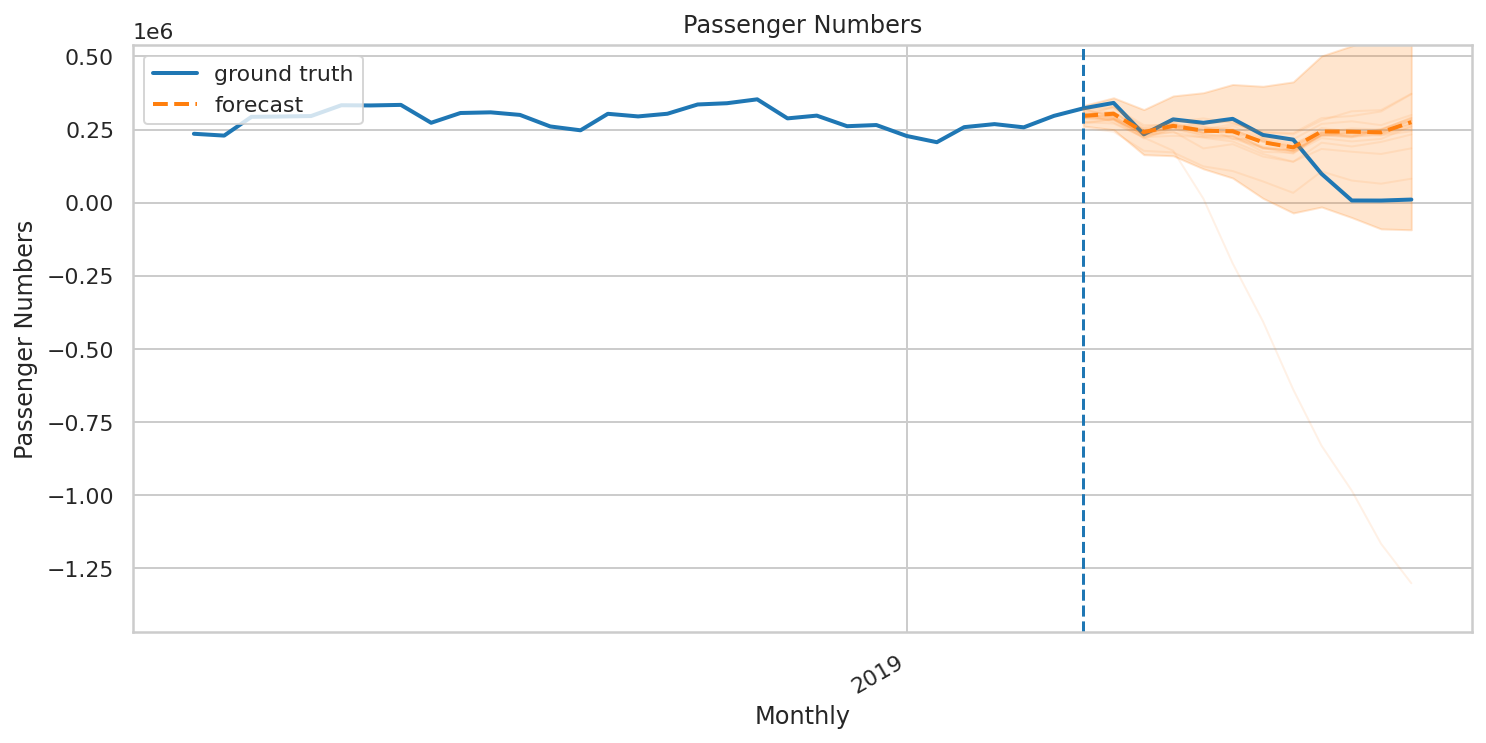

In [31]:
fig, ax = plot_forecast(
    tseries_dates, tseries,
    tseries_forecast_mean, tseries_forecast_scale, tseries_forecast_samples,
    x_locator=tseries_loc,
    x_formatter=tseries_fmt,
    title="Passenger Numbers")
ax.axvline(tseries_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Passenger Numbers")
ax.set_xlabel("Monthly")
fig.autofmt_xdate()

We can further understand the model's fit by decomposing it into the contributions of individual time series:

In [32]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    tseries_model,
    observed_time_series=tseries,
    parameter_samples=q_samples_tseries_)

In [33]:
tseries_component_means_, tseries_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

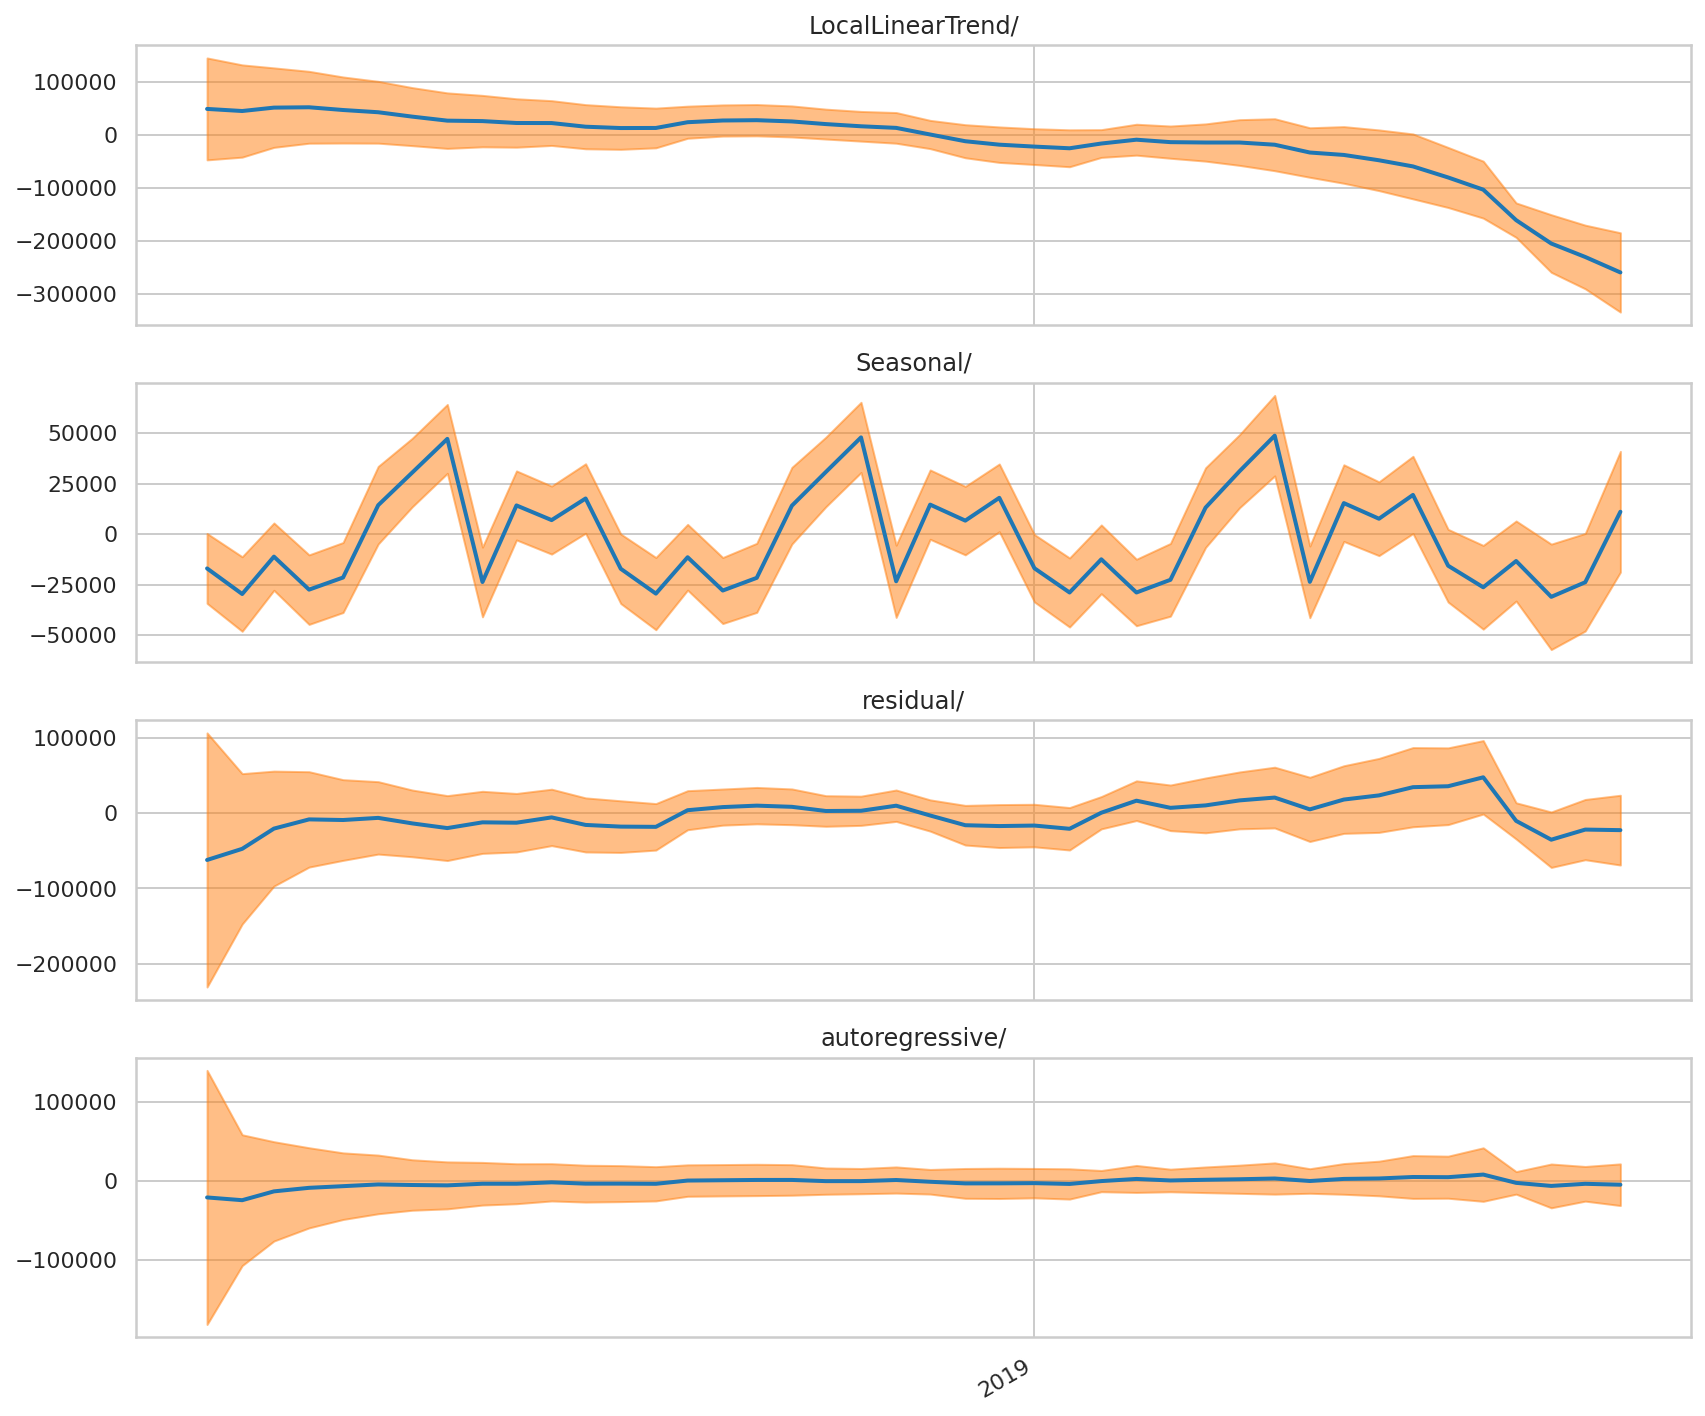

In [34]:
_ = plot_components(tseries_dates, tseries_component_means_, tseries_component_stddevs_,
                    x_locator=tseries_loc, x_formatter=tseries_fmt)